In [2]:
import json
from tqdm.notebook import tqdm
import psycopg2
import psycopg2.extras
from pprint import pprint
import datetime
from numpy import interp
import matplotlib.pyplot as plt

In [3]:
conn = psycopg2.connect(user='postgres', database="postgres", password='password', host='localhost', port='5432')
cursor = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

In [4]:
cursor.execute('SELECT DISTINCT music_id FROM play')

In [5]:
results = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]

In [6]:
def resultAsDict(result, colnames):
    d = {}
    for col in colnames:
        d[col] = result[colnames.index(col)]
    return d

In [7]:
musics = {}
for result in tqdm(results):
    music_id = result[0]
    musics[music_id] = {}
    cursor.execute('SELECT * FROM play WHERE music_id = ' + str(music_id))
    colnames = [desc[0] for desc in cursor.description]
    results_plays = cursor.fetchall()
    musics[music_id]['plays'] = []
    for p in results_plays:
        play = resultAsDict(p, colnames)
        musics[music_id]['plays'].append(play)
    cursor.execute('SELECT * FROM music WHERE music_id = ' + str(music_id))
    colnames = [desc[0] for desc in cursor.description]
    musics[music_id]['info'] = resultAsDict(cursor.fetchone(), colnames)

  0%|          | 0/7841 [00:00<?, ?it/s]

In [8]:
favorites = {}
cursor.execute('SELECT music_id FROM favorite')
results = cursor.fetchall()
for result in results:
    if result[0] not in favorites:
        favorites[result[0]] = 0
    favorites[result[0]] += 1

In [9]:
cursor.execute('SELECT * FROM music_artist')
results = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]

In [10]:
artists = {}
for result in tqdm(results):
    music = result[colnames.index('music_id')]
    if music not in musics:
        continue
    artist = result[colnames.index('artist_id')]
    if 'artists' not in musics[music]:
        musics[music]['artists'] = []
    if artist not in musics[music]['artists']:
        musics[music]['artists'].append(artist)
    
    if artist not in artists:
        artists[artist] = []
    if music not in artists[artist]:
        artists[artist].append(music)

  0%|          | 0/1127195 [00:00<?, ?it/s]

# Like Score Variables

- `repeat` = Número de Vezes que a música foi reproduzida
- `month_avg` = Quantas vezes por mês eu ouvi essa música? Durante o período em que eu ouvia
- `month_avg_alltime` = Quantas vezes por mês eu ouvi essa música? Desde o tempo que eu ouvi pela primeira vez
- `number_months` = Quantos meses eu fiquei ouvindo essa música
- `last` = Número de dias desde que eu ouvi a música pela última vez
- `favorites` = Número de vezes que ela foi adicionada nas playlists favoritas
- `artists_songs` = Número de Músicas do mesmo artista que ouvi (Músicas com apenas 1 artista)
- `track_done` = Número de vezes que a música foi reproduzida até o fim
- `skipped` = Número de vezes que eu pulei a música
- `replayed` = Número de Vezes que a música foi instantaneamente reprisada
- `duration_avr_total` = Tempo Médio que eu passei ouvindo a música em cada reprodução (% do total da música)

In [11]:
#Exported date today
today = datetime.date(2021,7,3)
for music in tqdm(musics):
    musics[music]['variables'] = {}
    
    # repeat
    musics[music]['variables']['repeat'] = len(musics[music]['plays'])
    
    # month_avg
    meses = {}
    for play in musics[music]['plays']:
        date = play['end_time']
        if str(date.year) + '-' + str(date.month) not in meses:
            meses[str(date.year) + '-' + str(date.month)] = 0
        meses[str(date.year) + '-' + str(date.month)] += 1
    musics[music]['variables']['month_avg'] = sum(meses.values()) / float(len(meses))
    
    # number_months
    musics[music]['variables']['number_months'] = len(meses)
    
    # month_avg_alltime
    first_time = musics[music]['plays'][0]['end_time']
    for play in musics[music]['plays']:
        date = play['end_time']
        if date < first_time:
            first_time = date
    for ano in range(first_time.year, today.year + 1):
        max_mes = 12
        min_mes = 1
        if ano == first_time.year:
            min_mes = first_time.month
        elif ano == today.year:
            max_mes = today.month

        for mes in range(min_mes, max_mes + 1):
            keyd = str(ano) + '-' + str(mes)
            if keyd not in meses:
                meses[keyd] = 0
            
    musics[music]['variables']['month_avg_alltime'] = sum(meses.values()) / float(len(meses))
    
    # last
    last_time = musics[music]['plays'][0]['end_time']
    for play in musics[music]['plays']:
        date = play['end_time']
        if date > first_time:
            last_time = date
            
    last = today - datetime.date(last_time.year, last_time.month, last_time.day)
    musics[music]['variables']['last'] = -last.days
    
    # favorites
    musics[music]['variables']['favorites'] = favorites.get(music, 0)
    
    # artists_songs
    artists_songs = []
    if len(musics[music]['artists']) == 1:
        artists_songs.extend(artists[musics[music]['artists'][0]])
    artists_songs = list(set(artists_songs))
    musics[music]['variables']['artists_songs'] = len(artists_songs)
    
    # track_done & skipped & replayed
    track_done = 0
    skipped = 0
    replayed = 0
    for play in musics[music]['plays']:
        if play['reason_end'] == 'fwdbtn':
            skipped += 1
        if play['reason_end'] == 'trackdone' or play['reason_end'] == 'endplay':
            track_done += 1
        if play['reason_start'] == 'backbtn':
            replayed += 1
    
    musics[music]['variables']['track_done'] = track_done
    musics[music]['variables']['skipped'] = -skipped
    musics[music]['variables']['replayed'] = replayed
    
    # duration_avr
    music_duration = musics[music]['info']['duration_ms']
    total_duration = 0
    for play in musics[music]['plays']:
        if play['ms_played'] > music_duration:
            total_duration += music_duration
            continue
        total_duration += play['ms_played']
    duration_avg = total_duration / float(len(musics[music]['plays']))
    musics[music]['variables']['duration_avr_total'] = duration_avg * 100 / music_duration
#     pprint(musics[music])
#     break

  0%|          | 0/7841 [00:00<?, ?it/s]

In [12]:
variables = list(musics[list(musics.keys())[0]]['variables'].keys())
for variable in variables:
    print('\n' + variable)
    d = {}
    for music in musics:
        d[musics[music]['info']['name'] + ' (' + str(musics[music]['info']['music_id']) + ')'] = musics[music]['variables'][variable]
    d_sorted = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
    for i in list(d_sorted.keys())[:10]:
        print('\t' + i + ': ' + str(d_sorted[i]))


repeat
	On prend des notes (559): 111
	Capsize (253): 102
	2 Heads (23): 101
	Á nos folies (129): 98
	New Rules (171): 96
	Wherever I Go (163): 90
	Feeling Good (807): 89
	FRIENDS (43): 88
	Dance Monkey (520): 87
	Bare (227): 83

month_avg
	Old Town Road (feat. Billy Ray Cyrus) - Remix (273): 14.5
	Birthday Suit (1387): 13.0
	Down In The Dirt (1021): 13.0
	Stay (feat. Gaby Henshaw) (1570): 10.0
	Believer (381): 10.0
	Chained To The Rhythm (903): 10.0
	Experience (2264): 10.0
	Vagabundo Também Ama / Vida Longa Mundo Pequeno - Acústico (398): 9.5
	good 4 u (2970): 9.0
	No Roots (2369): 9.0

number_months
	This Is What You Came For (feat. Rihanna) (130): 31
	2 Heads (23): 30
	Capsize (253): 30
	Stressed Out (530): 29
	Feeling Good (807): 28
	Something to Believe In (321): 28
	Ex's & Oh's (274): 27
	Sugar (105): 27
	7 Years (386): 26
	i hate u, i love u (feat. olivia o'brien) (541): 26

month_avg_alltime
	Paris (73): 8.11111111111111
	Exorcism (435): 7.444444444444445
	False Confidence (4

# Like Score Formula

In [13]:
variables = list(musics[list(musics.keys())[0]]['variables'].keys())
variables_max = {}
variables_min = {}
for variable in variables:
    d = {}
    for music in musics:
        d[musics[music]['info']['name'] + ' (' + str(musics[music]['info']['music_id']) + ')'] = musics[music]['variables'][variable]
    d_sorted = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
    variables_max[variable] = d_sorted[list(d_sorted.keys())[0]]
    variables_min[variable] = d_sorted[list(d_sorted.keys())[-1]]

In [14]:
variables_min

{'repeat': 1,
 'month_avg': 1.0,
 'number_months': 1,
 'month_avg_alltime': 0.014285714285714285,
 'last': -2083,
 'favorites': 0,
 'artists_songs': 0,
 'track_done': 0,
 'skipped': -39,
 'replayed': 0,
 'duration_avr_total': 0.0}

In [15]:
variables_max

{'repeat': 111,
 'month_avg': 14.5,
 'number_months': 31,
 'month_avg_alltime': 8.11111111111111,
 'last': 0,
 'favorites': 3,
 'artists_songs': 63,
 'track_done': 81,
 'skipped': 0,
 'replayed': 11,
 'duration_avr_total': 100.0}

In [17]:
# Defina o peso para cada uma das variáveis
pesos = {
    'repeat': 2,
    'month_avg': 2,
    'number_months': 2,
    'month_avg_alltime': 3,
    'last': 5,
    'favorites': 5,
    'artists_songs': 5,
    'track_done': 7,
    'skipped': 4,
    'replayed': 10,
    'duration_avr_total': 3,
}
ok = True
for var in variables:
    if var not in pesos:
        ok = False
        break

if not ok:
    print('Você esqueceu de definir peso em alguma das variáveis. Tenta copiar essa mensagem aqui:')
    print('pesos = {')
    for var in variables:
        if var not in pesos:
            print('    \'' + var + '\': 0, #<=== Esqueceu essa')
        else:
            print('    \'' + var + '\': ' + str(pesos[var]) + ',')
    print('}')

In [18]:
musics_score = {}
max_value = 0
for music in musics:
    like_score = 0
    for variable in variables:
        raw = musics[music]['variables'][variable]
        normalized = interp(raw,[variables_min[variable],variables_max[variable]],[0,1])
        like_score += pesos[variable] * normalized
#         print(pesos[variable])
    like_score = like_score / sum(pesos.values())
    if like_score > max_value:
        max_value = like_score
    musics[music]['like_score'] = like_score
    musics_score[musics[music]['info']['name'] + ' (' + str(musics[music]['info']['music_id']) + ')'] = like_score

In [19]:
fit_value = 1 / max_value
average = 0
for music in musics:
    val = musics[music]['like_score']
    musics[music]['like_score'] = val * fit_value
    average += val * fit_value
    musics_score[musics[music]['info']['name'] + ' (' + str(musics[music]['info']['music_id']) + ')'] = val * fit_value
average = average / float(len(musics))

In [20]:
musics_score_sorted = dict(sorted(musics_score.items(), key=lambda item: item[1], reverse=True))
for i in list(musics_score_sorted.keys())[:10]:
        print('\t' + i + ': ' + str(musics_score_sorted[i]))

	On prend des notes (559): 1.0
	Á nos folies (129): 0.9672863689494346
	FRIENDS (43): 0.8994036383467653
	Changing (292): 0.8208902982922096
	Exorcism (435): 0.8183174875236425
	Wherever I Go (163): 0.8128598821047716
	Dance Monkey (520): 0.779947305706358
	À peu près (31): 0.7774422071096757
	Hey Now (176): 0.7477221005105101
	Dusk Till Dawn - Radio Edit (210): 0.7457615855796061


2849 values above Average (0.2825907196525052)


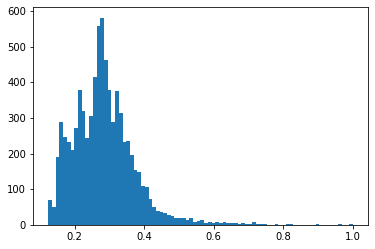

In [21]:
_ = plt.hist(musics_score_sorted.values(), bins='auto')
print(str(len([1 for i in musics_score_sorted.values() if i > 0.3])) + ' values above Average (' + str(average) + ')')

In [25]:
print(str(len([1 for i in musics_score_sorted.values() if i > 0.28])) + ' values above Average (' + str(average) + ')')

3702 values above Average (0.2825907196525052)


In [196]:
for music in musics:
    #print(musics[music])
    #break
    cursor.execute('UPDATE music SET like_rate=' + str(musics[music]['like_score']) + ' WHERE music_id = ' + str(music))

In [193]:
cursor.execute('SELECT * FROM music')
colnames = [desc[0] for desc in cursor.description]

In [194]:
colnames

['music_id',
 'music_spotify_uri',
 'name',
 'duration_ms',
 'popularity',
 'danceability',
 'energy',
 'music_key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'like_rate']

In [197]:
conn.commit()